Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,root_mean_squared_error
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from scipy.interpolate import interp1d
import tensorflow as tf
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional,Input
from tensorflow.keras.callbacks import EarlyStopping
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
features_df = pd.read_excel('aqua.xlsx', sheet_name='g4.areaAvgTimeSeries.MYD08_D3_6', skiprows=8)

In [ ]:
features_df.columns = ['Date', 'AOD']

In [ ]:
features_df['Date'] = pd.to_datetime(features_df['Date'])

In [ ]:
features_df.set_index('Date', inplace=True)

Missing Value Imputation

In [ ]:
features_df.isnull().sum()

,0
AOD,2193


In [ ]:
missing_percent = features_df['AOD'].isnull().mean() * 100

In [ ]:
print(f"Percentage of missing values: {missing_percent:.2f}%")

Percentage of missing values: 29.48%


In [ ]:
features_df['AOD'] = features_df['AOD'].interpolate(method='spline', order=3).fillna(method='bfill')

/tmp/ipython-input-9-1765457206.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  features_df['AOD'] = features_df['AOD'].interpolate(method='spline', order=3).fillna(method='bfill')


In [ ]:
features_df.shape

(7440, 1)

In [ ]:
features_df.isnull().sum()

,0
AOD,0


In [ ]:
features_df.head()

,AOD
Date,
2005-01-01,1.863
2005-01-02,1.863
2005-01-03,1.300
2005-01-04,0.298
2005-01-05,0.422


In [ ]:
features_df.tail()

,AOD
Date,
2025-05-27,0.409000
2025-05-28,0.786407
2025-05-29,0.810000
2025-05-30,0.786451
2025-05-31,1.061000


In [ ]:
features_df['AOD'].dtype

dtype('float64')

In [ ]:
aod_series = features_df['AOD'].copy()

In [ ]:
aod_series

,AOD
Date,
2005-01-01,1.863000
2005-01-02,1.863000
2005-01-03,1.300000
2005-01-04,0.298000
2005-01-05,0.422000
...,...
2025-05-27,0.409000
2025-05-28,0.786407
2025-05-29,0.810000


Feature Engineering

In [ ]:
features_df['year'] = features_df.index.year
features_df['month'] = features_df.index.month
features_df['day'] = features_df.index.day
features_df['day_of_year'] = features_df.index.dayofyear
features_df['week_of_year'] = features_df.index.isocalendar().week
features_df['AOD_lag1'] = features_df['AOD'].shift(1)
features_df['AOD_lag3'] = features_df['AOD'].shift(3)
features_df['AOD_lag7'] = features_df['AOD'].shift(7)
features_df['rolling_mean_7'] = features_df['AOD'].rolling(window=7).mean()
features_df['rolling_std_7'] = features_df['AOD'].rolling(window=7).std()
features_df['rolling_mean_30'] = features_df['AOD'].rolling(window=30).mean()
features_df.dropna(inplace=True)

In [ ]:
target_df = pd.read_excel('Aeronet_Ground.xlsx',skiprows=1)
target_df['Date'] = pd.to_datetime(target_df['Date'])
target_df.set_index('Date', inplace=True)

In [ ]:
print(target_df.columns)

Index(['AOD_550 nm'], dtype='object')


In [ ]:
df = features_df.merge(target_df[['AOD_550 nm']], left_index=True, right_index=True)

In [ ]:
df.dropna(subset=['AOD_550 nm'], inplace=True)  # critical step!

In [ ]:
df.head()

,AOD,year,month,day,day_of_year,week_of_year,AOD_lag1,AOD_lag3,AOD_lag7,rolling_mean_7,rolling_std_7,rolling_mean_30,AOD_550 nm
Date,,,,,,,,,,,,,
2010-01-08,1.267,2010,1,8,8,1,1.398,0.670958,1.448000,0.996529,0.331708,0.958474,1.328404
2010-01-12,1.429,2010,1,12,12,2,0.850,0.671131,0.670958,1.115590,0.308960,0.974451,1.023497
2010-01-13,1.328,2010,1,13,13,2,1.429,0.870000,1.324000,1.116162,0.309413,0.992618,1.545134
2010-01-14,2.099,2010,1,14,14,2,1.328,0.850000,1.398000,1.216305,0.481449,1.012384,0.804563
2010-01-15,0.063,2010,1,15,15,2,2.099,1.429000,1.267000,1.044305,0.646943,0.974218,0.685251


In [ ]:
df.tail()

,AOD,year,month,day,day_of_year,week_of_year,AOD_lag1,AOD_lag3,AOD_lag7,rolling_mean_7,rolling_std_7,rolling_mean_30,AOD_550 nm
Date,,,,,,,,,,,,,
2019-09-24,0.753415,2019,9,24,267,39,0.753402,0.753376,0.753325,0.753376,0.000028,0.729770,0.351707
2019-09-25,0.753428,2019,9,25,268,39,0.753415,0.753389,0.753338,0.753389,0.000028,0.729783,0.299810
2019-09-30,0.753493,2019,9,30,273,40,0.753480,0.753454,0.753402,0.753454,0.000028,0.731753,0.172924
2019-10-01,0.373000,2019,10,1,274,40,0.753493,0.753467,0.753415,0.699109,0.143800,0.719082,0.768491
2019-10-04,0.753544,2019,10,4,277,40,0.753531,0.373000,0.753454,0.699148,0.143818,0.728392,0.358606


In [ ]:
df.shape

(2421, 13)

Exploratory Data Visulations

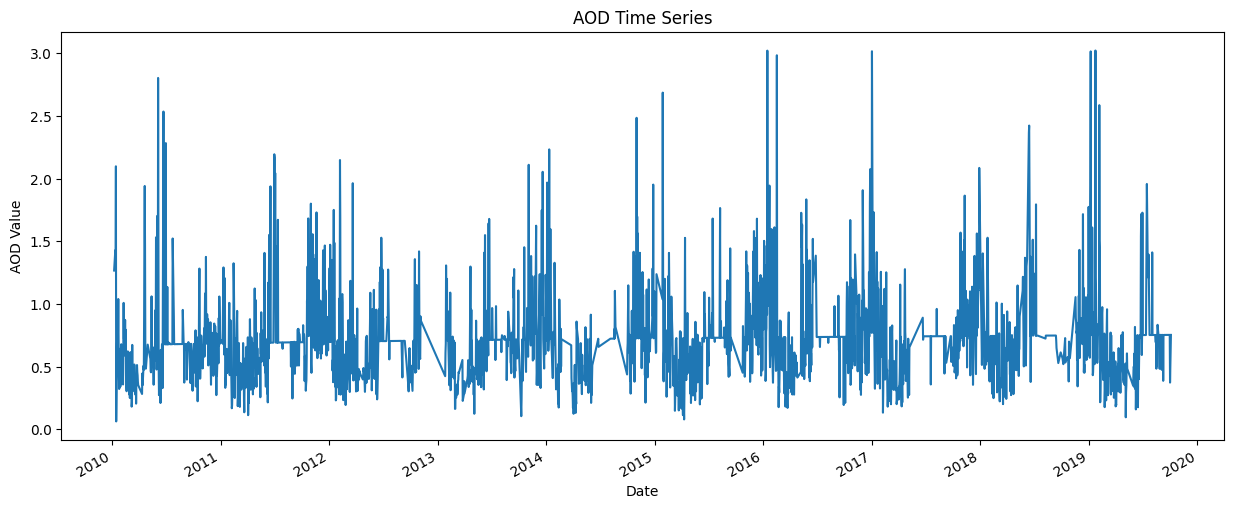

In [ ]:
plt.figure(figsize=(15, 6))
df['AOD'].plot(title='AOD Time Series')
plt.ylabel('AOD Value')
plt.show()

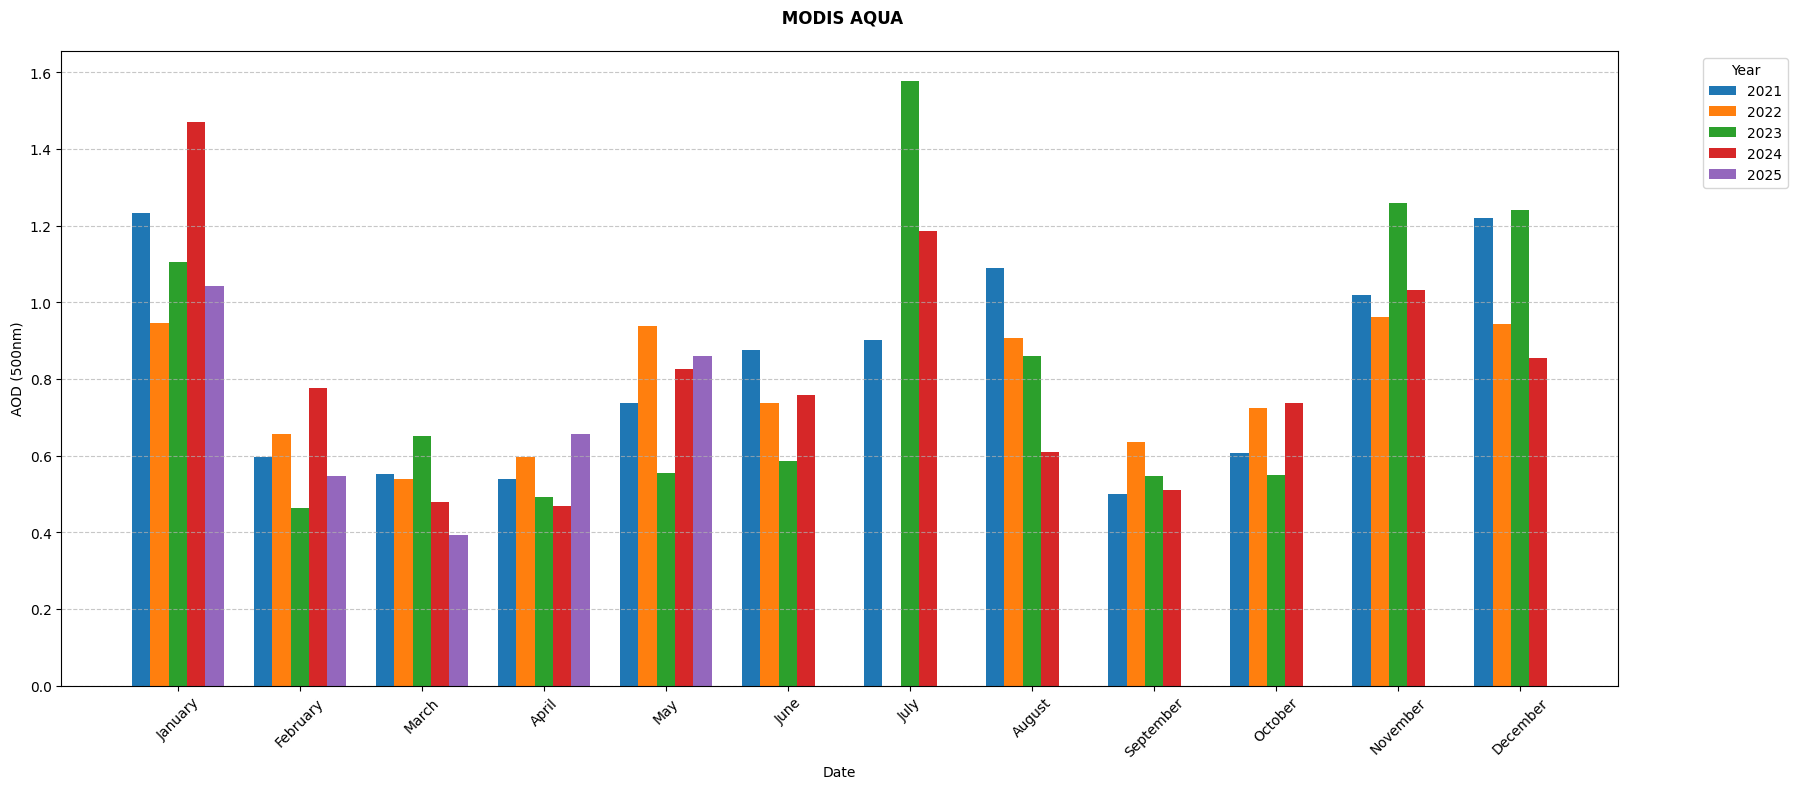

In [ ]:

# Load the data (replace with your actual Excel file path)
sd_df = pd.read_excel('aqua(montly-kanpur).xlsx', sheet_name='g4.areaAvgTimeSeries.MYD08_M3_6',skiprows=8)
sd_df['Date'] = pd.to_datetime(sd_df['time'])
sd_df = sd_df[(sd_df['Date'].dt.year >= 2021) & (sd_df['Date'].dt.year <= 2025)]

# Extract month and year
sd_df['Month'] = sd_df['Date'].dt.month_name()
sd_df['Year'] = sd_df['Date'].dt.year

# Pivot table for grouped bars
pivot_df = sd_df.pivot_table(index='Month', columns='Year', values='AOD_550nm', aggfunc='mean')

# Order months correctly
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
pivot_df = pivot_df.reindex(month_order)

# Plot
plt.figure(figsize=(18, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Distinct colors for each year
width = 0.15  # Width of each bar

for i, year in enumerate(pivot_df.columns):
    positions = np.arange(len(pivot_df)) + i * width
    plt.bar(positions, pivot_df[year], width=width, label=year, color=colors[i])

plt.title(' MODIS AQUA', fontweight='bold', pad=20)
plt.xlabel('Date')
plt.ylabel('AOD (500nm)')
plt.xticks(np.arange(len(pivot_df)) + width * 2, pivot_df.index, rotation=45)
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Outlier Detection and Removal

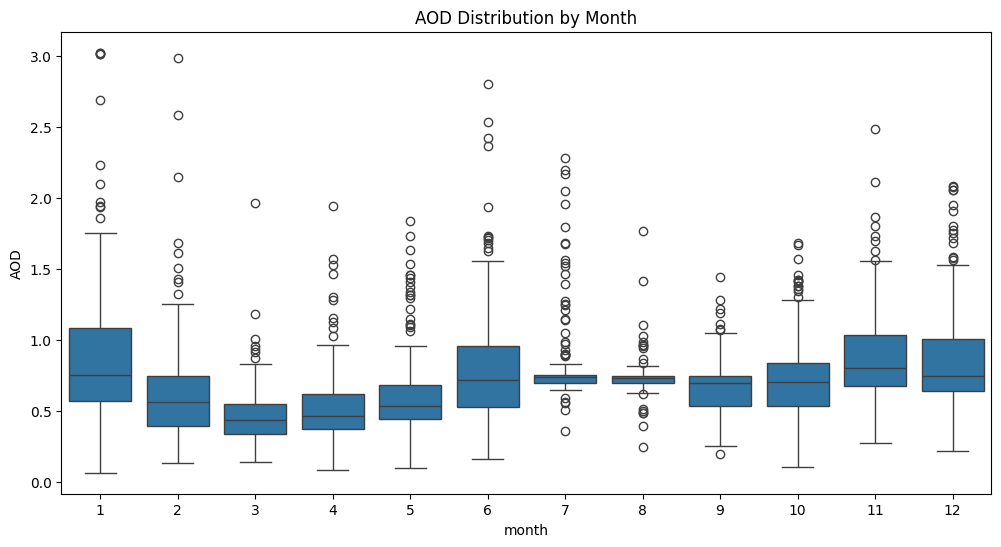

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='month', y='AOD', data=df)
plt.title('AOD Distribution by Month')
plt.show()

In [ ]:
z_scores = stats.zscore(df['AOD'])
abs_z_scores = np.abs(z_scores)
outliers = abs_z_scores > 3

In [ ]:
print(f"Number of outliers detected: {outliers.sum()}")

Number of outliers detected: 39


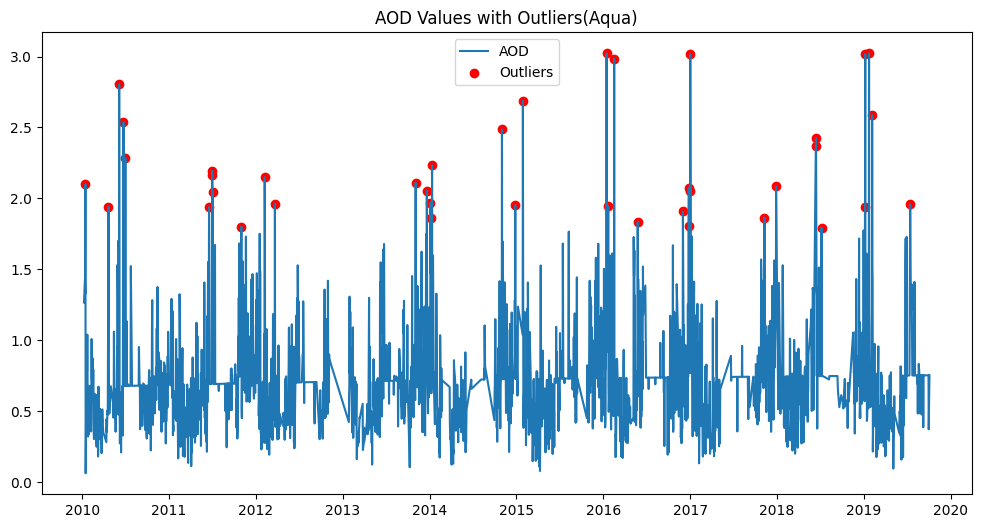

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['AOD'], label='AOD')
plt.scatter(df.index[outliers], df['AOD'][outliers], color='red', label='Outliers')
plt.title('AOD Values with Outliers(Aqua)')
plt.legend()
plt.show()

In [ ]:
mean_aod = df['AOD'].mean()
std_aod = df['AOD'].std()

In [ ]:
upper_bound = mean_aod + 3 * std_aod
lower_bound = mean_aod - 3 * std_aod

In [ ]:
df['AOD'] = df['AOD'].clip(lower=lower_bound, upper=upper_bound)

In [ ]:
df.head()

,AOD,year,month,day,day_of_year,week_of_year,AOD_lag1,AOD_lag3,AOD_lag7,rolling_mean_7,rolling_std_7,rolling_mean_30,AOD_550 nm
Date,,,,,,,,,,,,,
2010-01-08,1.267000,2010,1,8,8,1,1.398,0.670958,1.448000,0.996529,0.331708,0.958474,1.328404
2010-01-12,1.429000,2010,1,12,12,2,0.850,0.671131,0.670958,1.115590,0.308960,0.974451,1.023497
2010-01-13,1.328000,2010,1,13,13,2,1.429,0.870000,1.324000,1.116162,0.309413,0.992618,1.545134
2010-01-14,1.777982,2010,1,14,14,2,1.328,0.850000,1.398000,1.216305,0.481449,1.012384,0.804563
2010-01-15,0.063000,2010,1,15,15,2,2.099,1.429000,1.267000,1.044305,0.646943,0.974218,0.685251


In [ ]:
df.tail()

,AOD,year,month,day,day_of_year,week_of_year,AOD_lag1,AOD_lag3,AOD_lag7,rolling_mean_7,rolling_std_7,rolling_mean_30,AOD_550 nm
Date,,,,,,,,,,,,,
2019-09-24,0.753415,2019,9,24,267,39,0.753402,0.753376,0.753325,0.753376,0.000028,0.729770,0.351707
2019-09-25,0.753428,2019,9,25,268,39,0.753415,0.753389,0.753338,0.753389,0.000028,0.729783,0.299810
2019-09-30,0.753493,2019,9,30,273,40,0.753480,0.753454,0.753402,0.753454,0.000028,0.731753,0.172924
2019-10-01,0.373000,2019,10,1,274,40,0.753493,0.753467,0.753415,0.699109,0.143800,0.719082,0.768491
2019-10-04,0.753544,2019,10,4,277,40,0.753531,0.373000,0.753454,0.699148,0.143818,0.728392,0.358606


Feature Selection

In [ ]:
df.reset_index(inplace=True)

In [ ]:
X = df.drop(columns=[ 'AOD_550 nm','Date'])
y = df['AOD_550 nm']

In [ ]:
print(df['AOD_550 nm'].isnull().sum())

0


In [ ]:
print(df['AOD_550 nm'].isnull().sum())

0


In [ ]:
X

,AOD,year,month,day,day_of_year,week_of_year,AOD_lag1,AOD_lag3,AOD_lag7,rolling_mean_7,rolling_std_7,rolling_mean_30
0,1.267000,2010,1,8,8,1,1.398000,0.670958,1.448000,0.996529,0.331708,0.958474
1,1.429000,2010,1,12,12,2,0.850000,0.671131,0.670958,1.115590,0.308960,0.974451
2,1.328000,2010,1,13,13,2,1.429000,0.870000,1.324000,1.116162,0.309413,0.992618
3,1.777982,2010,1,14,14,2,1.328000,0.850000,1.398000,1.216305,0.481449,1.012384
4,0.063000,2010,1,15,15,2,2.099000,1.429000,1.267000,1.044305,0.646943,0.974218
...,...,...,...,...,...,...,...,...,...,...,...,...
2416,0.753415,2019,9,24,267,39,0.753402,0.753376,0.753325,0.753376,0.000028,0.729770
2417,0.753428,2019,9,25,268,39,0.753415,0.753389,0.753338,0.753389,0.000028,0.729783
2418,0.753493,2019,9,30,273,40,0.753480,0.753454,0.753402,0.753454,0.000028,0.731753
2419,0.373000,2019,10,1,274,40,0.753493,0.753467,0.753415,0.699109,0.143800,0.719082


In [ ]:
y

,AOD_550 nm
0,1.328404
1,1.023497
2,1.545134
3,0.804563
4,0.685251
...,...
2416,0.351707
2417,0.299810
2418,0.172924
2419,0.768491


Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

In [ ]:
X_train.shape

(1936, 12)

In [ ]:
X_test.shape

(485, 12)

In [ ]:
y_train.shape

(1936,)

In [ ]:
y_test.shape

(485,)

Feature Scaling

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
X_train_scaled

array([[ 1.78504592, -1.44641196, -1.49401997, ...,  1.39448345,
         0.542809  ,  1.57915336],
       [ 2.28690627, -1.44641196, -1.49401997, ...,  1.94888492,
         0.40700629,  1.6772242 ],
       [ 1.97401802, -1.44641196, -1.49401997, ...,  1.95154574,
         0.40971106,  1.78873684],
       ...,
       [ 2.72371063,  1.5883883 ,  1.04022886, ...,  0.56384202,
         0.55540083, -0.00912643],
       [ 0.211311  ,  1.5883883 ,  1.04022886, ...,  0.62371042,
         0.52551538,  0.01256226],
       [ 2.03287818,  1.5883883 ,  1.04022886, ...,  1.03613714,
         0.80851059,  0.114049  ]])

In [ ]:
X_test_scaled

array([[ 0.1214718 ,  1.5883883 ,  1.04022886, ...,  1.10465319,
         0.7397859 ,  0.12632562],
       [ 2.25902515,  1.5883883 ,  1.04022886, ...,  1.59424362,
         0.86687991,  0.25686702],
       [ 0.79991264,  1.5883883 ,  1.04022886, ...,  1.72928011,
         0.75620268,  0.2959476 ],
       ...,
       [ 0.19424959,  2.45547408,  0.75864566, ...,  0.26262226,
        -1.43727892,  0.18746539],
       [-0.98447971,  2.45547408,  1.04022886, ...,  0.00956843,
        -0.57897432,  0.10968928],
       [ 0.19440952,  2.45547408,  1.04022886, ...,  0.00974873,
        -0.57887238,  0.16683817]])

In [ ]:
y_train

,AOD_550 nm
0,1.328404
1,1.023497
2,1.545134
3,0.804563
4,0.685251
...,...
1931,0.719477
1932,0.790602
1933,1.377375
1934,1.091791


Model Training

Random Forest Regressor

In [ ]:
rf_model = RandomForestRegressor( n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42)

In [ ]:
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=300, random_state=42)

In [ ]:
rf_pred = rf_model.predict(X_test_scaled)

In [ ]:
rf_mse = mean_squared_error(y_test, rf_pred)
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = root_mean_squared_error(y_test, rf_pred)
rfr_rmse=r2_score(y_test,rf_pred)

In [ ]:
print("\nRandom Forest Performance:")
print(f"MSE: {rf_mse:.4f}")
print(f"MAE: {rf_mae:.4f}")
print(f"RMSE: {rf_r2:.4f}")
print(f"R2:{rfr_rmse:.4f}")


Random Forest Performance:
MSE: 0.0550
MAE: 0.1677
RMSE: 0.2345
R2:0.4969


Multi Layer Perceptron

In [ ]:
mlp_model = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    learning_rate_init=0.005,
    alpha=0.0001,
    batch_size=32,
    max_iter=5000,
    early_stopping=True,
    n_iter_no_change=20,
    random_state=42
)

In [ ]:
mlp_model.fit(X_train_scaled, y_train.ravel())

/tmp/ipython-input-58-1864286315.py:1: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  mlp_model.fit(X_train_scaled, y_train.ravel())


MLPRegressor(batch_size=32, early_stopping=True, hidden_layer_sizes=(100, 50),
             learning_rate_init=0.005, max_iter=5000, n_iter_no_change=20,
             random_state=42)

In [ ]:
mlp_pred = mlp_model.predict(X_test_scaled)

In [ ]:
mlp_mse = mean_squared_error(y_test, mlp_pred)
mlp_mae = mean_absolute_error(y_test, mlp_pred)
mlp_r2 = root_mean_squared_error(y_test, mlp_pred)
mlp_rmse=r2_score(y_test,mlp_pred)

In [ ]:
print("\nMLP Performance:")
print(f"MSE: {mlp_mse:.4f}")
print(f"MAE: {mlp_mae:.4f}")
print(f"RMSE: {mlp_r2:.4f}")
print(f"R2:{mlp_rmse:.4f}")


MLP Performance:
MSE: 0.0677
MAE: 0.1897
RMSE: 0.2602
R2:0.3805


Long Short Term Memory(LSTM)

In [ ]:
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

In [ ]:
n_steps = 30
X_lstm, y_lstm = create_sequences(df['AOD_550 nm'].values, n_steps)

In [ ]:
split_idx = int(0.8 * len(X_lstm))
split_idx

1912

In [ ]:
X_train_lstm, X_test_lstm = X_lstm[:split_idx], X_lstm[split_idx:]
y_train_lstm, y_test_lstm = y_lstm[:split_idx], y_lstm[split_idx:]

In [ ]:
X_train_lstm.shape

(1912, 30)

In [ ]:
X_test_lstm.shape

(479, 30)

In [ ]:
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

In [ ]:
X_train_lstm.shape

(1912, 30, 1)

In [ ]:
X_test_lstm.shape

(479, 30, 1)

In [ ]:
lstm_model = Sequential([
    Input(shape=(n_steps, 1)),
    Bidirectional(LSTM(128, activation='tanh', return_sequences=True)),
    Dropout(0.3),
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True)),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

In [ ]:
lstm_model.compile(optimizer='adam', loss='mse')

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

In [ ]:
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    validation_data=(X_test_lstm, y_test_lstm),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 0.1413 - val_loss: 0.0862
Epoch 2/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0881 - val_loss: 0.0819
Epoch 3/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0803 - val_loss: 0.0863
Epoch 4/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0845 - val_loss: 0.0839
Epoch 5/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0763 - val_loss: 0.0782
Epoch 6/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0782 - val_loss: 0.0766
Epoch 7/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0796 - val_loss: 0.0814
Epoch 8/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0779 - val_loss: 0.0813
Epoch 9/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0707 - val_loss: 0.0739
Epoch 10/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0748 - val_loss: 0.0713
Epoch 11/100
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0719 - val_loss: 0.0802
Epoch 12/100
120/120 ━━━━━━━━

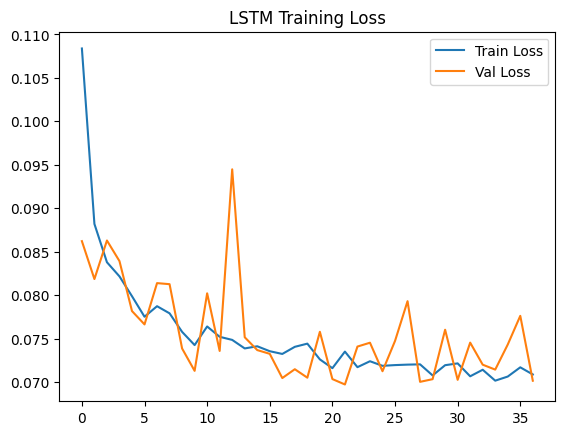

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("LSTM Training Loss")
plt.legend()
plt.show()

In [ ]:
y_pred_lstm = lstm_model.predict(X_test_lstm).flatten()

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [ ]:
lstm_mse = mean_squared_error(y_test_lstm, y_pred_lstm)
lstm_mae = mean_absolute_error(y_test_lstm, y_pred_lstm)
lstm_r2 = root_mean_squared_error(y_test_lstm, y_pred_lstm)
lstm_rmse=r2_score(y_test_lstm,y_pred_lstm)

In [ ]:
print("\nSimplified LSTM Performance:")
print(f"MSE: {lstm_mse:.4f}")
print(f"MAE: {lstm_mae:.4f}")
print(f"RMSE: {lstm_r2:.4f}")
print(f"R2:{lstm_rmse:.4f}")


Simplified LSTM Performance:
MSE: 0.0697
MAE: 0.1902
RMSE: 0.2641
R2:0.3375


In [ ]:
plt.figure(figsize=(18, 10))

# Define common axis limits
all_actual = np.concatenate([y_test, y_test_lstm])
all_predicted = np.concatenate([rf_pred, mlp_pred, y_pred_lstm])
ax_min = min(all_actual.min(), all_predicted.min()) * 0.9
ax_max = max(all_actual.max(), all_predicted.max()) * 1.1

<Figure size 1800x1000 with 0 Axes>

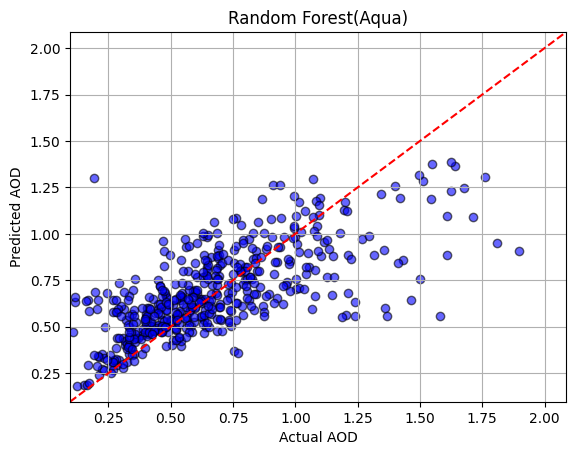

In [ ]:

plt.scatter(y_test, rf_pred, alpha=0.6, color='blue', edgecolor='k')
plt.plot([ax_min, ax_max], [ax_min, ax_max], 'r--')
plt.xlabel('Actual AOD')
plt.ylabel('Predicted AOD')
plt.title(f'Random Forest(Aqua)')
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.grid(True)

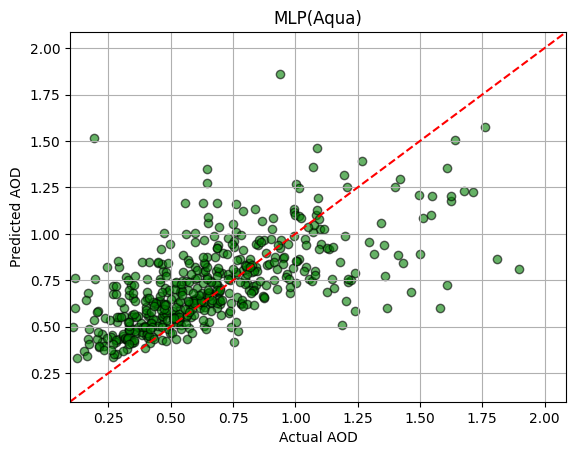

In [ ]:
plt.scatter(y_test, mlp_pred, alpha=0.6, color='green', edgecolor='k')
plt.plot([ax_min, ax_max], [ax_min, ax_max], 'r--')
plt.xlabel('Actual AOD')
plt.ylabel('Predicted AOD')
plt.title(f'MLP(Aqua)')
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.grid(True)

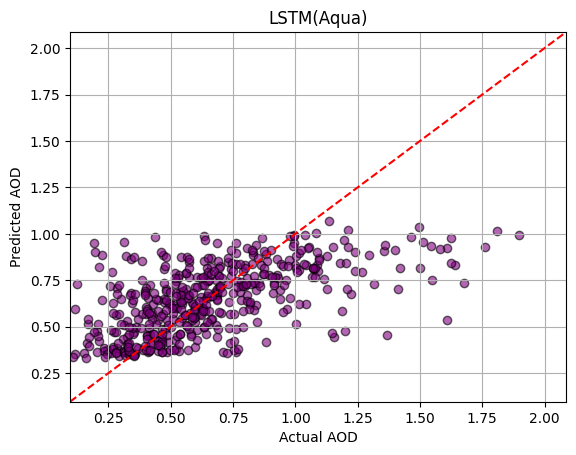

In [ ]:
plt.scatter(y_test_lstm, y_pred_lstm, alpha=0.6, color='purple', edgecolor='k')
plt.plot([ax_min, ax_max], [ax_min, ax_max], 'r--')
plt.xlabel('Actual AOD')
plt.ylabel('Predicted AOD')
plt.title(f'LSTM(Aqua)')
plt.xlim(ax_min, ax_max)
plt.ylim(ax_min, ax_max)
plt.grid(True)

In [ ]:
model_comparison = pd.DataFrame({
    'Model': ['Random Forest', 'MLP', 'LSTM'],
    'MSE': [rf_mse, mlp_mse, lstm_mse],
    'MAE': [rf_mae, mlp_mae, lstm_mae],
    'R²': [rf_r2, mlp_r2, lstm_r2]
})

In [ ]:
print("\nModel Comparison:")
print(model_comparison)
best_model_idx = np.argmin(model_comparison['MSE'])
best_model_name = model_comparison.loc[best_model_idx, 'Model']


Model Comparison:
           Model       MSE       MAE        R²
0  Random Forest  0.054972  0.167657  0.234461
1            MLP  0.067687  0.189740  0.260167
2           LSTM  0.069729  0.190160  0.264062


In [ ]:
aod_series.shape

(7440,)

In [ ]:
aod_series.index = pd.to_datetime(aod_series.index)

In [ ]:
aod_series = aod_series.asfreq('D').interpolate(method='time')

In [ ]:
n_days = 30
train = aod_series[:-n_days]
test = aod_series[-n_days:]

In [ ]:
model = ARIMA(aod_series, order=(1, 1, 1))
model_fit = model.fit()

In [ ]:
forecast = model_fit.forecast(steps=n_days)

In [ ]:
forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual_AOD': test.values,
    'Forecasted_AOD': forecast
}).set_index('Date')

In [ ]:
print("\n📋 Forecast Table (Last 30 Days):")
print(forecast_df)


📋 Forecast Table (Last 30 Days):
            Actual_AOD  Forecasted_AOD
Date                                  
2025-05-02    0.485000        0.939079
2025-05-03    1.135000        0.916332
2025-05-04    0.585000        0.912089
2025-05-05    0.785898        0.911297
2025-05-06    0.621000        0.911149
2025-05-07    0.440000        0.911122
2025-05-08    0.785964        0.911117
2025-05-09    0.570000        0.911116
2025-05-10    0.786008        0.911116
2025-05-11    1.491000        0.911116
2025-05-12    0.391000        0.911116
2025-05-13    0.537000        0.911116
2025-05-14    0.497000        0.911116
2025-05-15    0.535000        0.911116
2025-05-16    1.064000        0.911116
2025-05-17    0.521000        0.911116
2025-05-18    0.795000        0.911116
2025-05-19    0.958000        0.911116
2025-05-20    0.934000        0.911116
2025-05-21    0.899000        0.911116
2025-05-22    0.668000        0.911116
2025-05-23    0.786296        0.911116
2025-05-24    1.497000        

In [ ]:
forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual_AOD': test.values,
    'Forecasted_AOD': forecast
}).set_index('Date')

In [ ]:
model = SARIMAX(train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 30),
                enforce_stationarity=False,
                enforce_invertibility=False)

In [ ]:
model_fit = model.fit(disp=False)

In [ ]:
forecast = model_fit.forecast(steps=n_days)

In [ ]:
forecast_df = pd.DataFrame({
    'Date': test.index,
    'Actual_AOD': test.values,
    'Forecasted_AOD': forecast
}).set_index('Date')

print("\n SARIMA Forecast Table:")
print(forecast_df.head(10))


 SARIMA Forecast Table:
            Actual_AOD  Forecasted_AOD
Date                                  
2025-05-02    0.485000        0.926545
2025-05-03    1.135000        0.867980
2025-05-04    0.585000        0.850062
2025-05-05    0.785898        0.863729
2025-05-06    0.621000        0.853097
2025-05-07    0.440000        0.852205
2025-05-08    0.785964        0.856633
2025-05-09    0.570000        0.874882
2025-05-10    0.786008        0.877179
2025-05-11    1.491000        0.853894
